This project predicts if the stock price of a company will increase or decrease based on top news headlines

In [1]:
!pip install vaderSentiment
!pip install textblob

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# 1. Understand the Dataset:

In [3]:
df = pd.read_csv("stock_news.csv")
print(df.head())
print(df.shape)

   Unnamed: 0                                           headline     label
0           0  Markets Close Mostly Lower Again; ROST, PANW R...  Negative
1           1  Gap plummets on earnings miss, cuts full-year ...  Negative
2           2  Billionaire Ken Fisher is Selling These 10 Stocks  Negative
3           3          Corning net income drops 13%, shares fall  Negative
4           4  Internet Explorer shutdown to cause Japan prob...  Negative
(26000, 3)


In [4]:
nltk.download("punkt")
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
nltk.download("punkt")
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

if "Combined_News" not in df.columns:
    headline = []
    for row in range(0, len(df.index)):
        text = " ".join(str(x) for x in df.iloc[row, 2:])  
        headline.append(text)
    df["Combined_News"] = headline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
clean_headline = []
for text in df["Combined_News"]:
    text = re.sub(r"[^a-zA-Z ]", " ", str(text))  
    text = text.lower()
    tokens = word_tokenize(text)
    text = " ".join(lemmatizer.lemmatize(tok) for tok in tokens if len(tok) > 2)
    clean_headline.append(text)

df["Cleaned"] = clean_headline

In [7]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

sia = SentimentIntensityAnalyzer()

df["Subjectivity"] = df["Cleaned"].apply(get_subjectivity)
df["Polarity"] = df["Cleaned"].apply(get_polarity)

compound, neg, pos, neu = [], [], [], []
for text in df["Cleaned"]:
    score = sia.polarity_scores(text)
    compound.append(score["compound"])
    neg.append(score["neg"])
    pos.append(score["pos"])
    neu.append(score["neu"])

df["compound"] = compound
df["neg"] = neg
df["pos"] = pos
df["neu"] = neu

In [8]:
df["Sentiment_Label"] = df["compound"].apply(
    lambda x: 0 if x <= -0.05 else (2 if x >= 0.05 else 1)
)

print(df[["Cleaned", "compound", "Sentiment_Label"]].head())

    Cleaned  compound  Sentiment_Label
0  negative   -0.5719                0
1  negative   -0.5719                0
2  negative   -0.5719                0
3  negative   -0.5719                0
4  negative   -0.5719                0


In [9]:
tfidf = TfidfVectorizer(max_features=5000, stop_words="english", lowercase=True, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["Cleaned"])

sentiment_feats = df[["Subjectivity", "Polarity", "compound", "neg", "pos", "neu"]].to_numpy()
X = np.hstack([sentiment_feats, X_tfidf.toarray()])

y = df["Sentiment_Label"].to_numpy()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train, y_train)
y_pred = lda_model.predict(x_test)

print("\n📊 LDA Classification Report:")
print(classification_report(y_test, y_pred, digits=2, target_names=["Down", "Neutral", "Up"]))
print("LDA Accuracy:", accuracy_score(y_test, y_pred))



📊 LDA Classification Report:
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00       961
     Neutral       1.00      1.00      1.00      1749
          Up       1.00      1.00      1.00      2490

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200

LDA Accuracy: 1.0


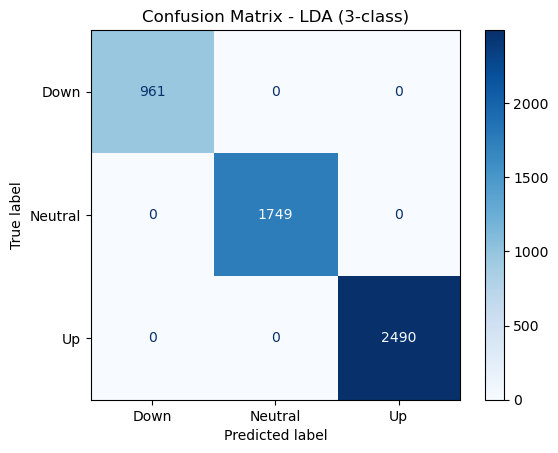

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Neutral", "Up"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LDA (3-class)")
plt.show()


In [13]:
gnb_model = GaussianNB().fit(x_train, y_train)
print("\nGaussianNB Accuracy:", accuracy_score(y_test, gnb_model.predict(x_test)))

lr_model = LogisticRegression(max_iter=1000).fit(x_train, y_train)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_model.predict(x_test)))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(x_train, y_train)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_model.predict(x_test)))



GaussianNB Accuracy: 1.0
Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 1.0


In [14]:
# -------------------------------
joblib.dump(lda_model, "stock_sentiment_model2.pkl")
print("\n✅ Model saved as stock_sentiment_model2.pkl")


✅ Model saved as stock_sentiment_model2.pkl
